In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import os


In [24]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [25]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', tsname ='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [26]:
def plot_ts_and_points(tser, start_point, step):
    new_series = [None for i in range(len(tser))]
    for i in range(len(tser)):
        pos = start_point + step * i
        if pos >= len(tser):
            break
        new_series[pos] = tser[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        tser.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

In [27]:
os.chdir(r'd:\ml\временные ряды')

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


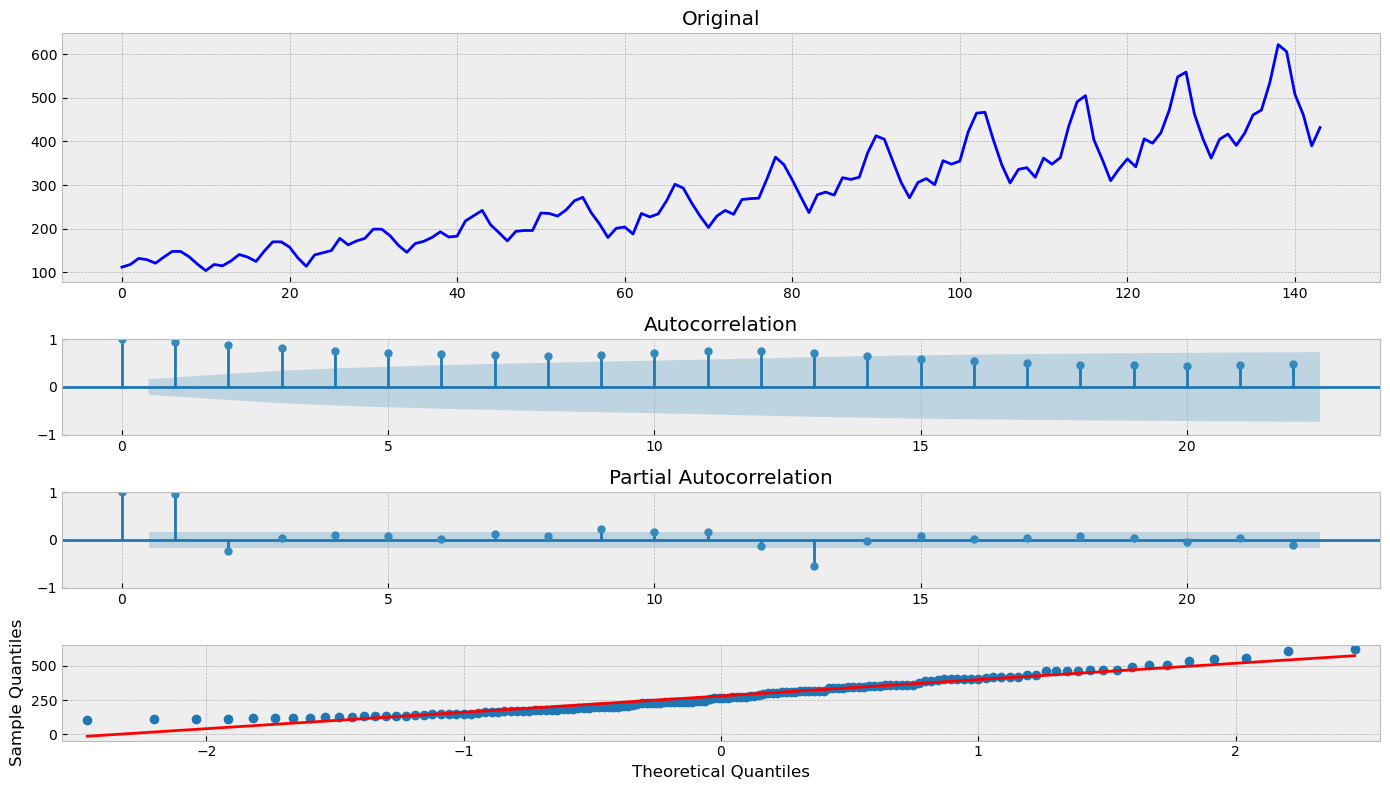

In [28]:
ts = pd.read_csv("Series/international-airline-passengers.csv")['Count']
nplt = 'international-airline-passengers'
tsplot(ts,tsname = nplt)

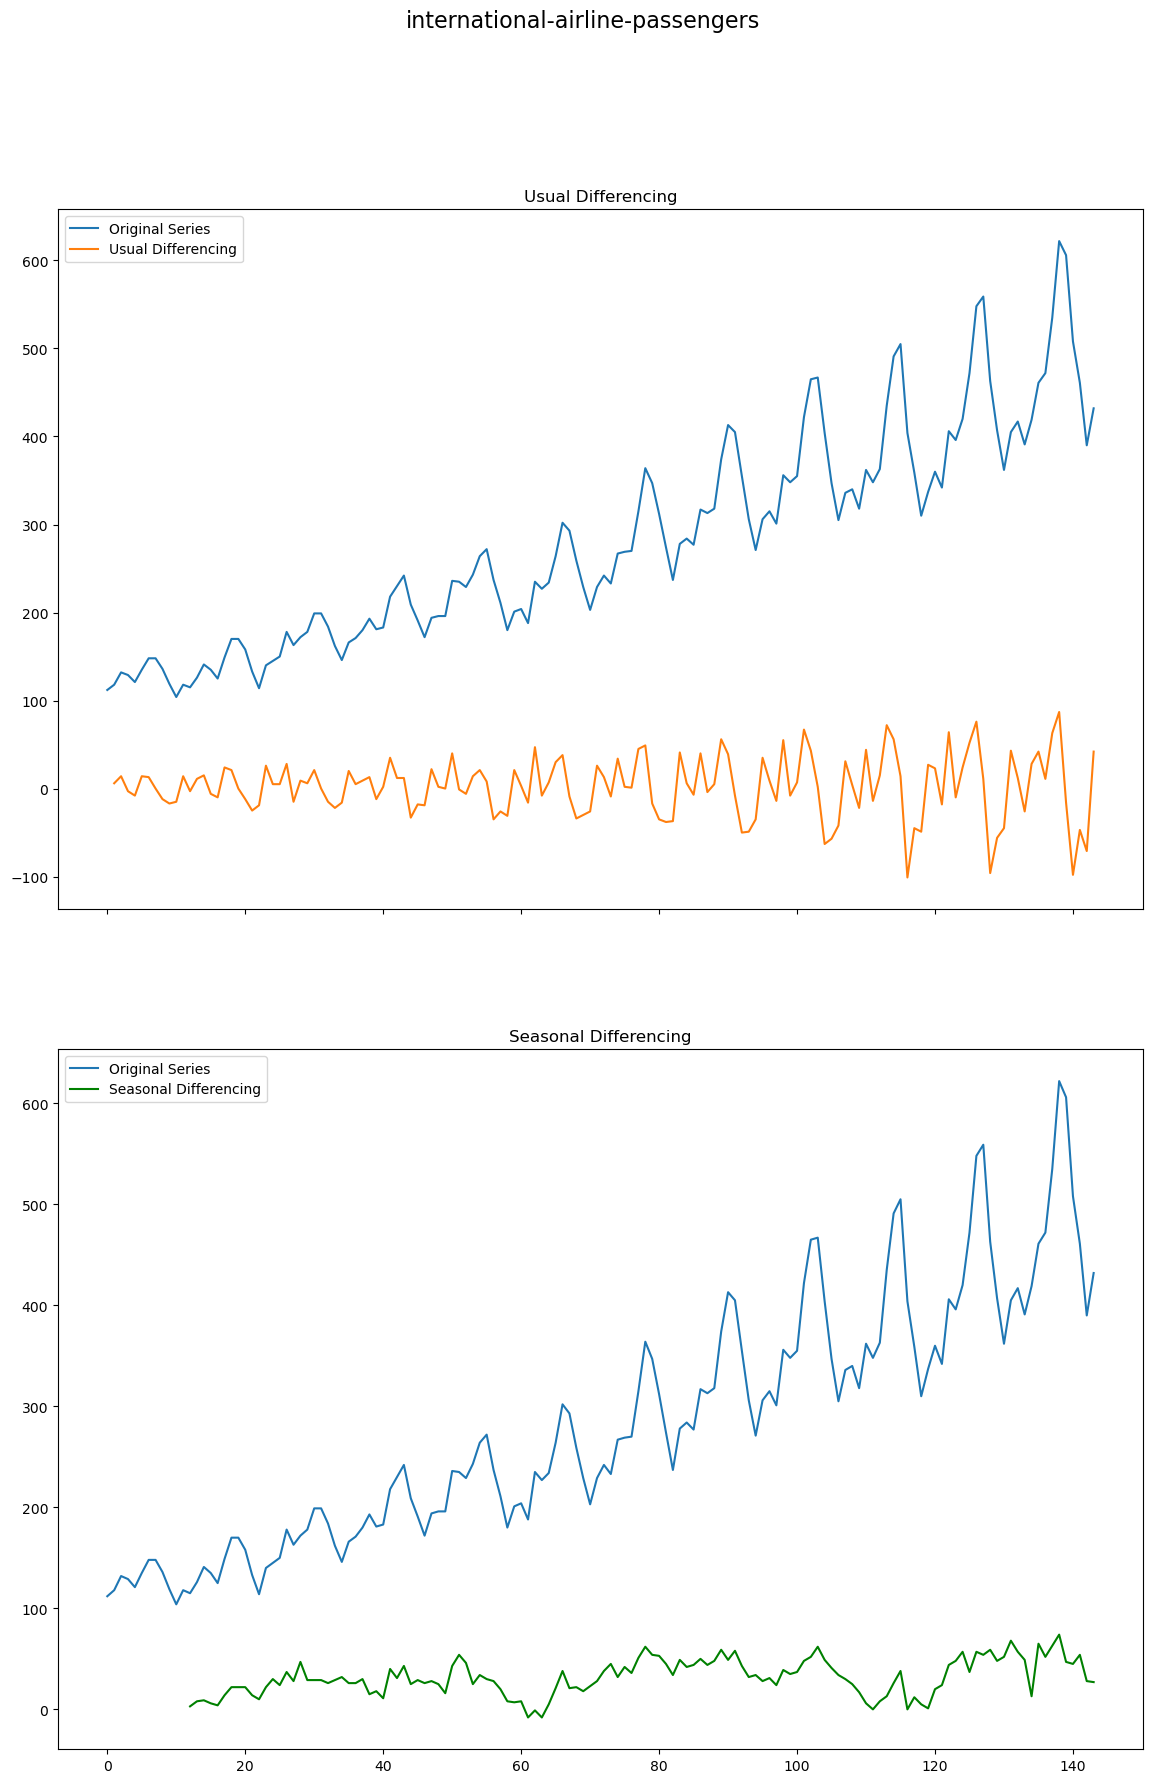

In [29]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(14,20), dpi=100, sharex=True)
#
# Usual Differencing
axes[0].plot(ts, label='Original Series')
axes[0].plot(ts.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(ts, label='Original Series')
axes[1].plot(ts.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('international-airline-passengers', fontsize=16)
plt.show()

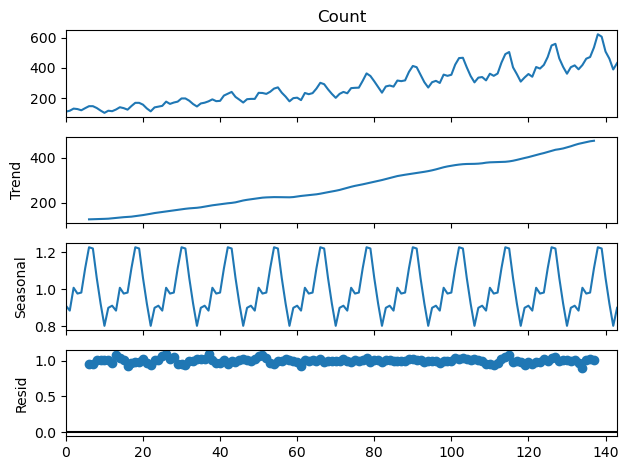

In [30]:
# проверим на сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(ts, model ='multiplicative', period = 12)
res.plot() 
plt.show()

Прослеживается явная сезонность и тренд.

In [31]:
import itertools

In [32]:
# убираем и тренд и сезонность
ts = np.diff(ts, 1)
ts = np.diff(ts, 12)

Results of Dickey-Fuller Test:
Test Statistic                -1.762486e+01
p-value                        3.823047e-30
#Lags Used                     1.300000e+01
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


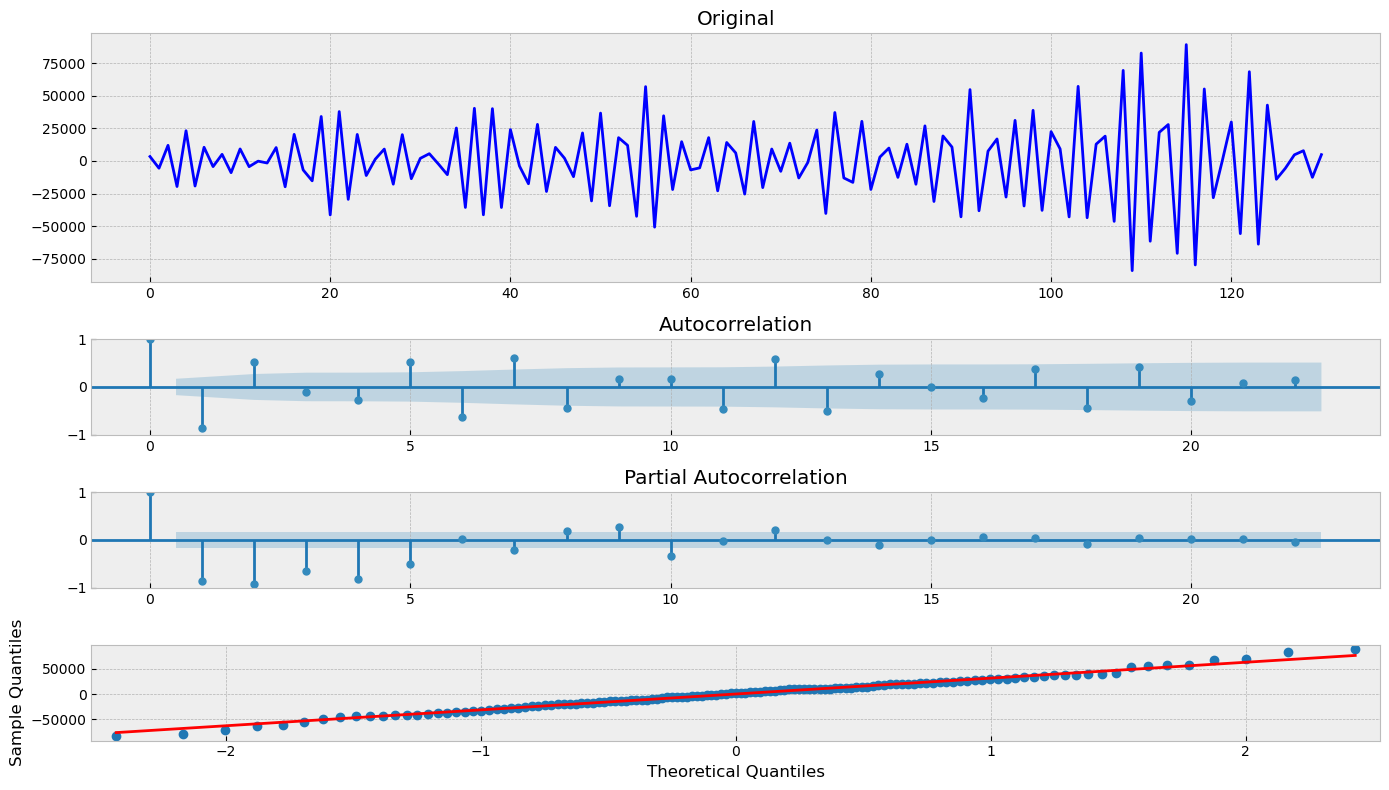

In [33]:
tsplot(ts,tsname = nplt)

In [35]:
p = range(0,10)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf
for params in pdq:
  model_test = ARIMA(ts, order = params, enforce_stationarity=False)
  result_test = model_test.fit()
  if result_test.aic < best_aic:
    best_pdq = params
    best_aic = result_test.aic
print(best_pdq, best_aic)

(9, 1, 0) 1966.0599944477972


In [36]:
model = ARIMA(ts, order = (9,1,0))
result = model.fit()

In [37]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  131
Model:                 ARIMA(9, 1, 0)   Log Likelihood               -1069.814
Date:                Sat, 09 Mar 2024   AIC                           2159.628
Time:                        18:31:52   BIC                           2188.303
Sample:                             0   HQIC                          2171.279
                                - 131                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -5.1862      0.057    -91.749      0.000      -5.297      -5.075
ar.L2        -13.5491      0.268    -50.538      0.000     -14.075     -13.024
ar.L3        -23.4965      0.640    -36.735      0.000     -24.750     -22.243
ar.L4        -29.9459      1.009    -29.676      0.000     -31.924     -27.968
ar.L5        -29.0685      1.163    -24.993      0.000     -31.348     -26.789
ar.L6        -21.4194      1.009    -21.236      0.000     -23.396     -19.442
ar.L7        -11.4573      0.648    -17.691      0.000     -12.727     -10.188
ar.L8         -3.9759      0.281    -14.129      0.000      -4.527      -3.424
ar.L9         -0.6690      0.064    -10.531      0.000      -0.794      -0.545
sigma2      5.655e+05   1.46e-05   3.87e+10      0.000    5.65e+05    5.65e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.37   Jarque-Bera (JB):                 7.06
Prob(Q):                              0.04   Prob(JB):                         0.03
Heteroskedasticity (H):               1.84   Skew:                            -0.27
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.03e+26. Standard errors may be unstable.
"""

Results of Dickey-Fuller Test:
Test Statistic                -8.452768e+00
p-value                        1.645312e-13
#Lags Used                     1.000000e+01
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64


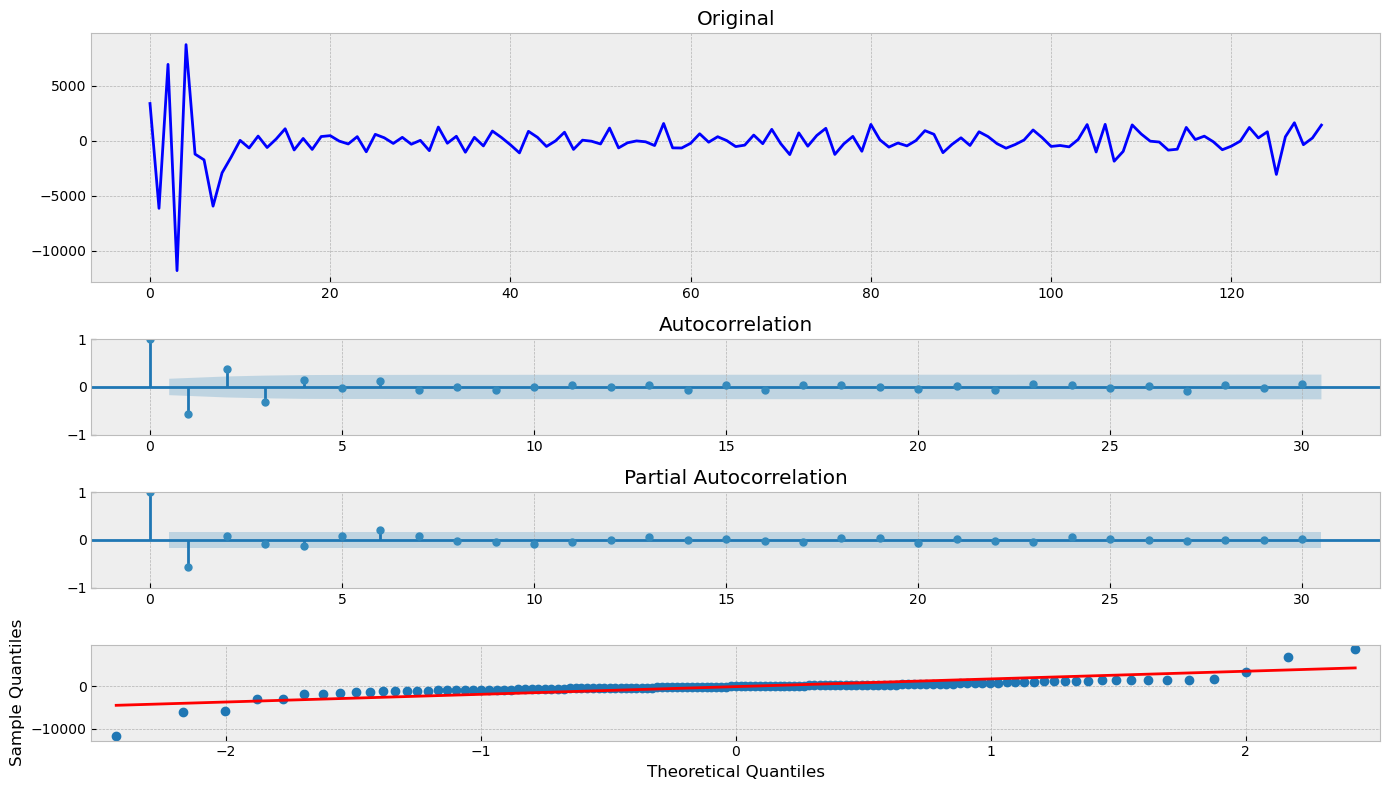

In [39]:
tsplot(result.resid, tsname = nplt, lags = 30)

Попробуем подобрать параметры с помощью библиотеки pmdarima

In [42]:
ts = pd.read_csv("Series/international-airline-passengers.csv")['Count']

In [43]:

import pmdarima as pm
model = pm.auto_arima(ts, start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.17 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.18 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.11 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.20 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.28 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.16 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.07 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(0,1,1)(1,1,1)[12]     

In [44]:
# В итоге сезонность 12 предлагаются следующие парметры модели ARIMA(0,1,1)(2,1,0)[12]

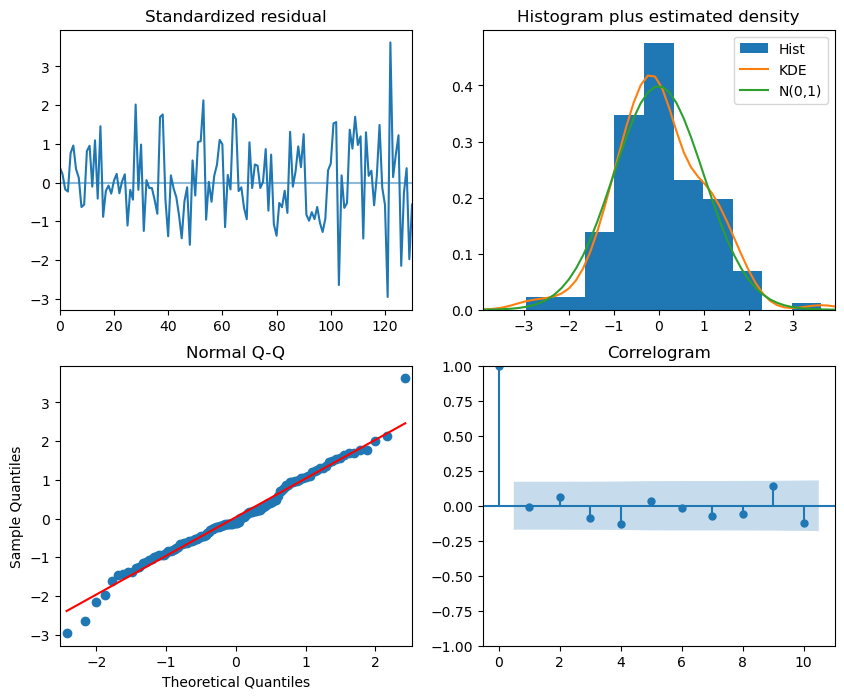

In [45]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

- Остаточные ошибки, по-видимому, колеблются вокруг среднего значения, равного нулю, и имеют равномерную дисперсию, есть выбросы 
- Нормальное распределение
- Теоретические квантили: В основном точки идеально совпадают с красной линией за исключением старта и конца
-  остаточные ошибки не являются автокоррелированными
В целом модель подходит, берем ее для прогнозирования

In [46]:
n_periods = 12
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)

In [47]:
# предсказания 
fitted

144    451.347076
145    427.102222
146    463.382490
147    499.705770
148    514.035525
149    571.851867
150    661.310508
151    648.081675
152    551.284691
153    501.068279
154    434.052983
155    479.233767
dtype: float64

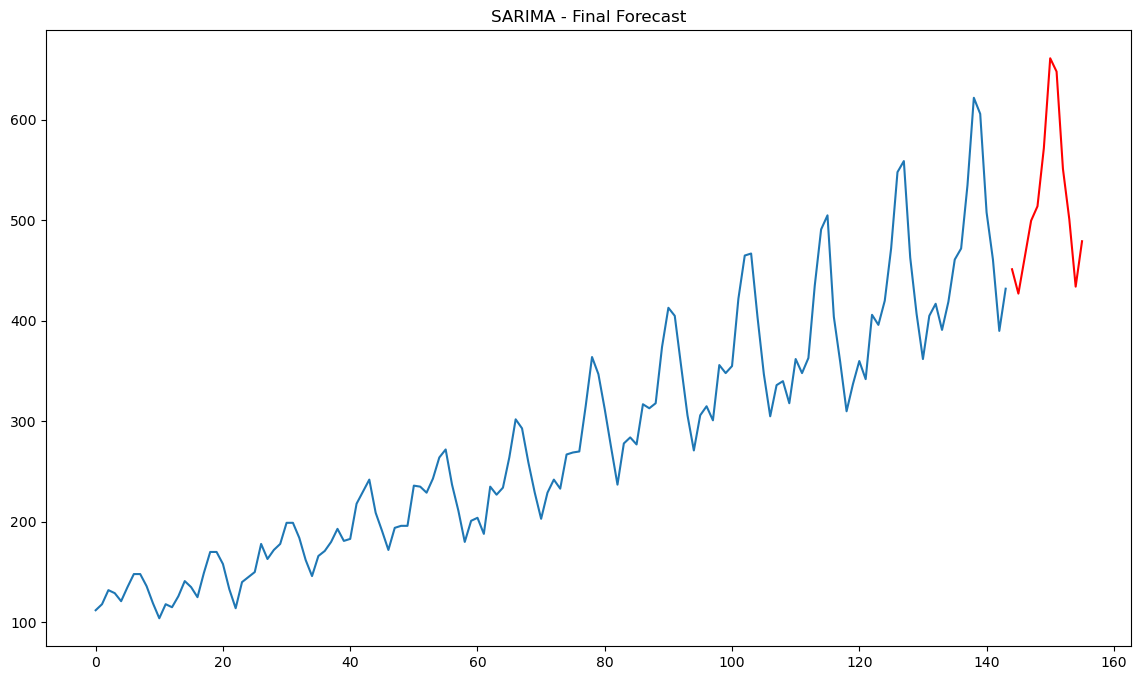

In [48]:

figsize=(14,8)
plt.figure(figsize=figsize)

plt.plot (ts)
plt.plot(fitted, color='red')

plt.title("SARIMA - Final Forecast")
plt.show()

Cпрогнозируем график классическим ML

In [49]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ['reg']
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['reg'].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["reg"], axis=1)
    y_train = data.loc[:test_index]["reg"]
    X_test = data.loc[test_index:].drop(["reg"], axis=1)
    y_test = data.loc[test_index:]["reg"]
    
    return X_train, X_test, y_train, y_test

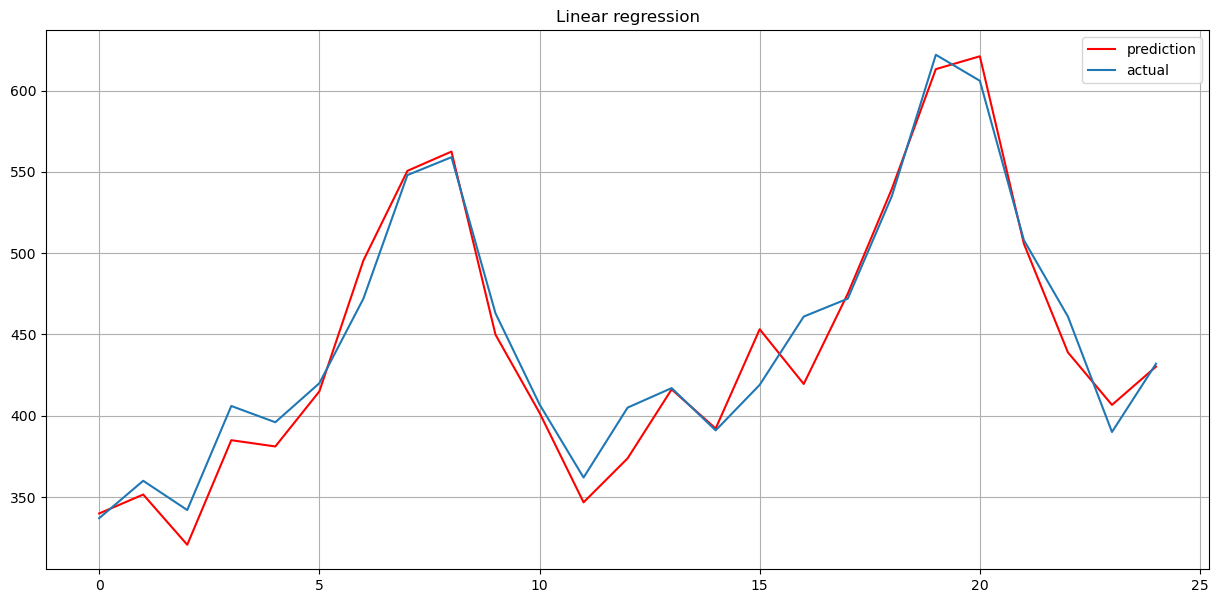

In [50]:
X_train, X_test, y_train, y_test = prepareData(ts, test_size=0.3, lag_start=1, lag_end=20)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title('Linear regression')
plt.grid(True);

На тестовых данных в этом конктетном временном ряде линйная регрессия показывает хороший результат